### 1. Import and data loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

In [2]:
df = pd.read_csv("../data/chess_games_feature.csv")
df.head()

,WhiteElo,BlackElo,ResultNumeric,EventTypeID,RatingDiff,AvgRating,WhiteIsHigherRated,WhiteRatingAdvantage,ECOID,w_material_early,...,w_castled_early,b_castled_early,w_checks_early,b_checks_early,early_checks,w_piece_activity,b_piece_activity,both_castled_early,total_captures_early,activity_diff
0,2487,2596,1,0,109,2541.5,0,-109,0,20.0,...,1.0,0.0,4.0,2.0,6.0,36.0,36.0,0,15.0,0.0
1,2542,2433,2,0,109,2487.5,1,109,9,16.0,...,0.0,0.0,1.0,3.0,4.0,31.0,20.0,0,15.0,11.0
2,2404,2534,0,0,130,2469.0,0,-130,0,21.0,...,1.0,1.0,0.0,0.0,0.0,33.0,34.0,1,9.0,-1.0
3,2860,2922,1,0,62,2891.0,0,-62,0,33.0,...,1.0,0.0,0.0,0.0,0.0,39.0,39.0,0,4.0,0.0
4,2752,2395,2,0,357,2573.5,1,357,0,18.0,...,0.0,1.0,0.0,1.0,1.0,38.0,28.0,0,14.0,10.0


### 2. Prepare data

In [3]:
X = df.drop('ResultNumeric', axis=1)
y = df['ResultNumeric']

print(f"Features: {X.shape}")
print(f"Target: {y.shape}")

Features: (2435474, 33)
Target: (2435474,)


### 3. Train test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,        # 20% for testing
    random_state=42,
    stratify=y
)

#### Scale feature

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 4. Train model

In [6]:
lr_model = LogisticRegression(
    max_iter=2000,
    solver='saga',
    random_state=42,
    n_jobs=-1,
)

In [7]:
start_time = time.time()

lr_model.fit(X_train_scaled, y_train)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

Training completed in 27.01 seconds (0.45 minutes)


### 5. Evaluate

In [8]:
y_pred = lr_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)\n")

print("Classification Report: \n")
print(classification_report(y_test, y_pred, target_names=['Black Win', 'Draw', 'White Win']))

Accuracy: 0.6109 (61.09%)

Classification Report: 

              precision    recall  f1-score   support

   Black Win       0.60      0.64      0.62    198257
        Draw       0.70      0.31      0.43     77234
   White Win       0.61      0.69      0.65    211604

    accuracy                           0.61    487095
   macro avg       0.64      0.55      0.56    487095
weighted avg       0.62      0.61      0.60    487095



### 6. Confusion Matrix

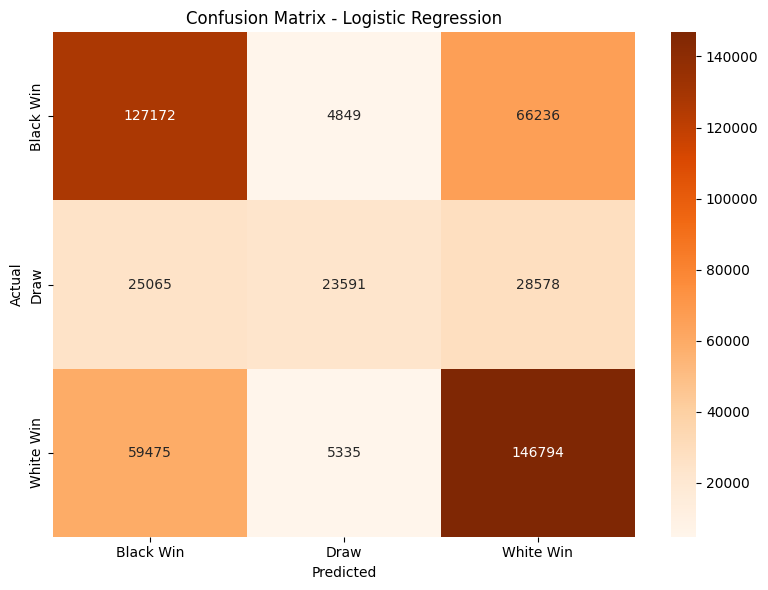

In [9]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Black Win', 'Draw', 'White Win'],
            yticklabels=['Black Win', 'Draw', 'White Win'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Logistic Regression')
plt.tight_layout()
plt.show()

### 7. Coefficients (Feature importance for linear models)

                  Feature  Coefficient
6    WhiteRatingAdvantage     0.183420
10    material_diff_early     0.153291
1                BlackElo     0.134785
0                WhiteElo     0.133835
4               AvgRating     0.127007
2             EventTypeID     0.101928
3              RatingDiff     0.070017
8        w_material_early     0.064563
32          activity_diff     0.063848
9        b_material_early     0.058044
28       w_piece_activity     0.043731
29       b_piece_activity     0.039520
13     capture_diff_early     0.033112
30     both_castled_early     0.024972
16  aggression_diff_early     0.024554
21          b_development     0.020969
5      WhiteIsHigherRated     0.018174
11       w_captures_early     0.016701
27           early_checks     0.016162
7                   ECOID     0.015967
25         w_checks_early     0.015738
20          w_development     0.015659
26         b_checks_early     0.015495
17       w_center_control     0.015327
24        b_castled_early

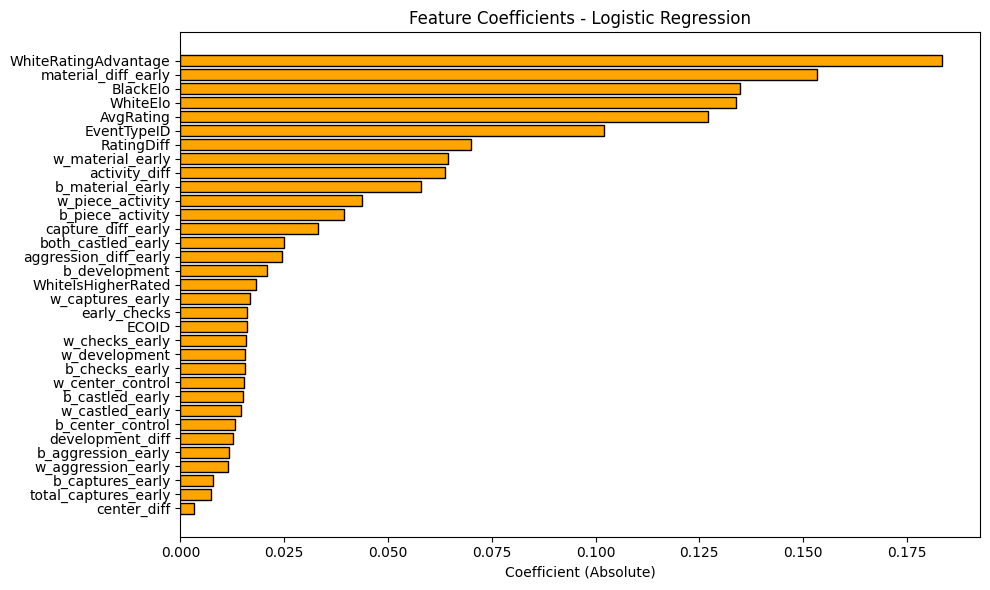

In [10]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': np.abs(lr_model.coef_).mean(axis=0)  # Average across classes
}).sort_values('Coefficient', ascending=False)

print(coef_df)

plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], 
         color='orange', edgecolor='black')
plt.xlabel('Coefficient (Absolute)')
plt.title('Feature Coefficients - Logistic Regression')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()